# CR Hamiltonian tomography using OpenPulse

In this Jupyter notebook we show how to investigate Hamiltonian of cross resonance (CR) pulse. We do this by measuring a statevector of target qubit at each pulse duration of CR Rabi experiment [1]. This notebook does the following steps

1) Create quantum circuit abstruction of CR pulse sequence to measure.

2) Add CR pulse duration sweep and state tomography circuit.

3) Create fitter to reconstruct CR Hamiltonian.  

---
Check the following reference for the detailed description.  
  
[1] Sheldon, S., Magesan, E., Chow, J. M. & Gambetta, J. M. Procedure for systematically tuning up cross-talk in the cross-resonance gate. Phys. Rev. A 93, 060302 (2016).  
[2] Magesan, E. & Gambetta, J. M. Effective Hamiltonian models of the cross-resonance gate. (2018).

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from qiskit import IBMQ, transpile, schedule, assemble
from qiskit.ignis.characterization.hamiltonian import create_cr_circuit, cr_hamiltonian_tomography_circuits, CrossResonanceHamiltonianFitter

## 1. Load backend supporting OpenPulse
Backend should support OpenPulse and level2 measurement. If level2 measurement is not supported, use discriminator module to convert level1 result into level2.

In [2]:
IBMQ.load_account()
ibmq_provider = IBMQ.get_provider(hub='hub', group='group', project='project')
backend = ibmq_provider.get_backend('backend')

In [3]:
conf = backend.configuration()

## 2. Creating CR Rabi schedule
First you need create the circuit abstruction of CR pulse sequence. This is automatically done with `create_cr_circuit` function. This function create CR sequence with and without echoing. You can create echoed CR sequence with `use_echo=True`. By default, the function outputs echoed CR and the echoed CR is used to eliminate strong IX interaction in this notebook. Cancellation tone is omitted. If you want to apply cancellation, you need to add `ca_amp` key to `parameters` below.

Generated circuit is passed to `cr_hamiltonian_tomography_circuits`. This function output a list of `QuantumCircuits` to meaure CR Rabi with all measurement basis in the Pauli basis. The circuits should be transpiled and converted into pulse schedule before execution.

In [4]:
parameters = {'cr_amp': 0.3, 'sigma': 64, 'risefall': 128}
durations = np.linspace(512, 4096, 15, dtype=int)
qubit_pair = 0, 1
shots = 1024

In [5]:
# pulse channel to show in pulse visualizer
channels = [conf.drive(0), conf.drive(1), conf.measure(0), conf.measure(1), conf.control(0)]

Create circuit to be tomographed. The circuit has gate abstraction of pulse schedule with variable pulse duration.

In [6]:
cr_circ, ext_maps, ext_gates = create_cr_circuit(qubit_pair=qubit_pair, backend=backend, cross_resonance_params=parameters)
# add pi-pulse
ext_gates += ['x']

In [7]:
cr_circ.draw(idle_wires=False)

Add CR Rabi sweep and state tomography circuit.

In [8]:
cr_rabi_circs, xdata = cr_hamiltonian_tomography_circuits(qubit_pair=qubit_pair, cr_circ=cr_circ, cr_durations=durations, resolution=backend.configuration().dt)

In [9]:
print(cr_rabi_circs[4].name)
cr_rabi_circs[4].draw(idle_wires=False)

cr_ham_tomo_sched_0_y_1


Convert circuits into pulse schedules.

In [10]:
cr_rabi_circs = transpile(cr_rabi_circs, backend, basis_gates=ext_gates)
scheds = schedule(cr_rabi_circs, backend, ext_maps)

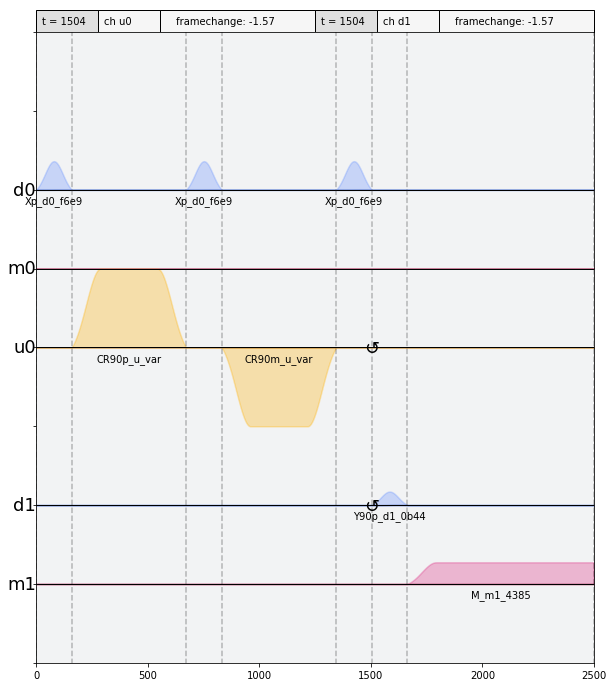

In [11]:
scheds[4].draw(channels=channels, label=True, plot_range=(0, 2500))

Run experiments.

In [12]:
cr_qobj = assemble(scheds, backend, meas_level=2, shots=shots)
cr_job = backend.run(cr_qobj)
cr_results = cr_job.result(timeout=3600)

Fit the result.

In [13]:
cr_fit = CrossResonanceHamiltonianFitter(cr_results, xdata, [qubit_pair], fit_p0=[0, 0, 0], fit_bounds=None)

In [14]:
# fit data for control state = 0
cr_fit.fit_data(qid=0, p0=[-8e6, 8e6, 0], series='0')
# fit data for control state = 1
cr_fit.fit_data(qid=0, p0=[8e6, -8e6, 0], series='1')

Plot fit result.

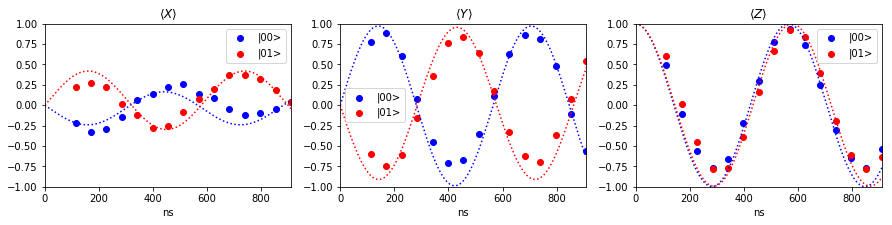

(<matplotlib.axes._subplots.AxesSubplot at 0x7f893fc0eac8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f893f9c3cf8>)

In [15]:
cr_fit.plot_rabi()

Plot transition of bloch vector with cross resonance pulse duration. Plot starts from blue point and ends in green point.

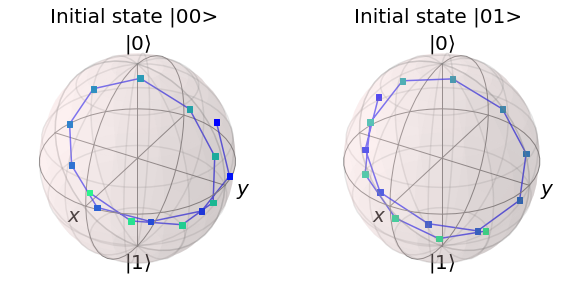

(<matplotlib.axes._subplots.Axes3DSubplot at 0x7f893fe5cdd8>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x7f89405d6cc0>)

In [16]:
cr_fit.plot_bloch()

Finally, you can get CR Hamiltonian. Components displayed as `n/a` cannot be determined by this technique.

In [17]:
cr_fit.hamiltonian

{(0, 1): {'II': 'n/a',
  'IX': 'n/a',
  'IY': 'n/a',
  'IZ': 'n/a',
  'XI': -372348.28817503527,
  'XX': 'n/a',
  'XY': 'n/a',
  'XZ': -10512242.14505034,
  'YI': 815338.7293585467,
  'YX': 'n/a',
  'YY': 'n/a',
  'YZ': -3024191.9514292767,
  'ZI': -570007.1698237062,
  'ZX': 'n/a',
  'ZY': 'n/a',
  'ZZ': 144380.27241572857}}